In [1]:
import sys
#sys.path.append('C:/Users/Fabian/Documents/gempy')
sys.path.insert(0, '/home/bl9/gempy')
import gempy as gp

%matplotlib inline
import pymc
import numpy as np
import math

from IPython.core.display import Image

from pymc.Matplot import plot
from pymc import graph

from IPython.core.pylabtools import figsize
figsize(15, 6)

import scipy.optimize as sop
import scipy.stats as stats
from scipy.signal import argrelextrema

import matplotlib.mlab as mlab
from matplotlib import pyplot as plt

import importlib

from operator import itemgetter

from mpl_toolkits.mplot3d import Axes3D

import vtk
import evtk

from scipy.interpolate import griddata

import decision_making as dm

/home/bl9/gempy/gempy/plotting/visualization.py:36: UserWarning: Steno 3D package is not installed. No 3D online visualization available.
  warnings.warn('Steno 3D package is not installed. No 3D online visualization available.')


In [2]:
# Importing the data from csv files and setting extent and resolution
geo_data = gp.create_data([0,1000,0,1000,0,1000],[50,50,50],
                         path_o = ".././input_data/simple_dome_orientations1.csv",
                         path_i = ".././input_data/simple_dome_points1.csv")
geo_data.n_faults = 0

In [3]:
gp.set_series(geo_data, {"Dome":('Shale')},
                       order_series = ["Dome",], order_formations=['Shale',])

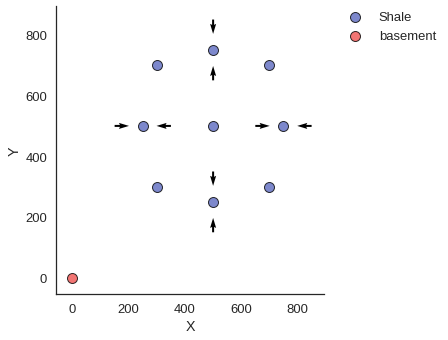

In [4]:
figsize(20,10)
gp.plotting.plot_data(geo_data,direction='z')

In [5]:
# Groups considering top view on spill line:
# From A to H clockwise, starting at center left
# Central points are a separate group (nan)

geo_data.interfaces['group_id']

0      A
1      G
2      C
3      E
4      H
5      B
6      F
7      D
8    NaN
9    NaN
Name: group_id, dtype: object

In [6]:
interp_data = gp.InterpolatorData(geo_data, 
                                   u_grade = [3], dtype ='float64')

In [7]:
lith_sol, fault_sol = gp.compute_model(interp_data)

Compiling theano function...
Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0


In [8]:
base_n = int(geo_data.formations.loc['basement','formation_number'].values[0])
#sandstone_n = int(geo_data.formations.loc['Sandstone','formation_number'].values[0])
shale_n = int(geo_data.formations.loc['Shale','formation_number'].values[0])

In [9]:
#sst_surf_v, sst_surf_s = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], n_formation = sandstone_n)
shale_surf_v, shale_surf_s = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], n_formation = shale_n)

In [10]:
# DECLARING SOME MODEL VARIABLES
resolution = geo_data.resolution[1] #resolution, standard: 50
model_size = geo_data.extent[:2][1] # 'real' model extent, here: 2000 m - cubic (what if not cubic?)
scale_factor = (model_size/resolution) # scale factor used for calculating voxel volumes in [m]
                                        # here: 2000/50 = 40
rescale_f = interp_data.rescaling_factor # rescaling factor from geo_data to interp_data

minmax_buffer = True # buffer around local min and max values [on/off] - not used atm

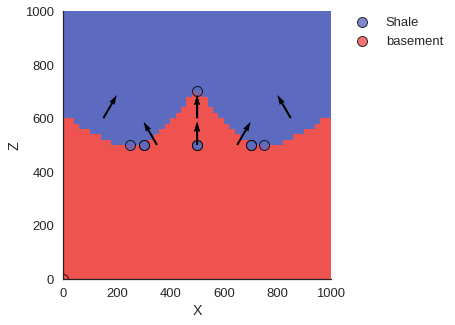

In [11]:
%matplotlib inline
figsize(20,10)
gp.plotting.plot_section(geo_data, lith_sol[0], int(resolution/2), plot_data=1, direction='y')

In [40]:
def spill_leak_P(interp_data, res_surf, lith, fault_presence = geo_data.n_faults, print_figures=True):    
    
    # creating a grid with uniform distances for vertices of the reservoir surface
    grid_x, grid_y = np.meshgrid(np.unique(interp_data.geo_data_res.grid.values[:, 0]),
                             np.unique(interp_data.geo_data_res.grid.values[:, 1]))

    #grid_x=(grid_x*rescale_f)-(np.min(grid_x)*rescale_f)
    #grid_y=(grid_y*rescale_f)-(np.min(grid_y)*rescale_f)
    grid_x=(grid_x)-(np.min(grid_x))
    grid_y=(grid_y)-(np.min(grid_y))
    
    grid_z0 = griddata(res_surf[:,:2], res_surf[:,2],
                       (grid_x, grid_y), method='linear')
    
    # order of values that serve to find relative extrema (min/max)
    rel_order_maxX = 5
    rel_order_maxY = 10
    rel_order_minX = 5
    rel_order_minY = 5
    
    # check grid_z0 for max and min in directions x and y
    # direction X
    minX1,minX2 = argrelextrema(grid_z0,np.less,order=rel_order_minX,axis=1)
    maxX1,maxX2 = argrelextrema(grid_z0,np.greater,order=rel_order_maxX,axis=1)
    grid_minX = np.zeros_like(grid_z0)
    grid_minX[minX1,minX2]=1           # grid of min in X
    grid_maxX = np.zeros_like(grid_z0)
    grid_maxX[maxX1,maxX2]=1           # grid of max in X
    
    #direction Y
    minY1,minY2 = argrelextrema(grid_z0,np.less,order=rel_order_minY,axis=0)
    maxY1,maxY2 = argrelextrema(grid_z0,np.greater,order=rel_order_maxY,axis=0)
    grid_minY = np.zeros_like(grid_z0)
    grid_minY[minY1,minY2]=1           # grid of min in Y
    grid_maxY = np.zeros_like(grid_z0)
    grid_maxY[maxY1,maxY2]=1           # grid of max in Y
    
    # fault leak line: defining line of juxtaposition, point of cross-fault leakage to be found on it
    # check for minima line that is on hanging wall side compared to max contact of layer top with fault
    fault_max_line_bool = np.copy(grid_maxX)
    fault_max_line = fault_max_line_bool.argmax(axis=1)
    fault_max = np.max(fault_max_line) # max of fault-layer contact as threshold        
    fleak_line = np.copy(grid_minX).astype(int)
    fleak_line[:,fault_max:]=0 # only returns minima at hanging wall side
    
    # minmax buffering
    # to set neighboring values of min and max to min and max respectively, too 
    if minmax_buffer:
        minXroll1 = np.logical_or(grid_minX,np.roll(grid_minX,1, axis=0))
        minXroll1[:,:fault_max] = 0
        minXroll2 = np.logical_or(grid_minX,np.roll(grid_minX,-1, axis=0))
        minXroll2[:,:fault_max] = 0
        minXbuffer = np.logical_or(minXroll1, minXroll2)
        grid_minX = np.logical_or(grid_minX, minXbuffer)
        #grid_maxX = np.logical_or(grid_maxX,np.roll(grid_maxX,1))
        #grid_maxX = np.logical_or(grid_maxX,np.roll(grid_maxX,-1))
        #grid_minY = np.logical_or(grid_minY,np.roll(grid_minY,1))
        #grid_minY = np.logical_or(grid_minY,np.roll(grid_minY,-1))
        grid_maxY = np.logical_or(grid_maxY,np.roll(grid_maxY,1, axis=1))
        grid_maxY = np.logical_or(grid_maxY,np.roll(grid_maxY,-1, axis=1))
    
    #check for saddle points
    saddle_p1 = np.logical_and(grid_minX,grid_maxY)
    saddle_p2 = np.logical_and(grid_minY,grid_maxX)
    saddle_p_all= np.logical_or(saddle_p1, saddle_p2)
    
    # this should find saddle points relative to X and Y directions
    # problem of finding other points in a rotated direction?
    ### NOT FINISHED: DEFINE LEAK POINT OVER LEAK LINE MAX?
    
    if fault_presence == 0:
        pot_spill_points = saddle_p_all
        
        pot_spill_Xcoord = grid_x[pot_spill_points]
        pot_spill_Ycoord = grid_y[pot_spill_points]
        pot_spill_Zcoord = grid_z0[pot_spill_points]    
        pot_spill_3Dcoord = np.array(list(zip(pot_spill_Xcoord, pot_spill_Ycoord, pot_spill_Zcoord)))
        
        if pot_spill_3Dcoord.size == 0:
            anticline_spill_3Dcoord = np.array([]) # if no leak coordinates found, set to empty array
        else:
            max_spill_pos = pot_spill_3Dcoord[:,2].argmax(axis=0)
            anticline_spill_3Dcoord = pot_spill_3Dcoord[max_spill_pos,:]
            
        if print_figures==True:
            figsize(15,6)
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            #ax.scatter(grid_x, grid_y, grid_z0, c="b", alpha = 0.1)
            ax.scatter(grid_x, grid_y, grid_minY, c="b", alpha = 0.1)
            ax.scatter(grid_x, grid_y, grid_maxY, c="r", alpha = 0.1)
            ax.scatter(grid_x, grid_y, grid_minX, c="b", alpha = 0.1)
            ax.scatter(grid_x, grid_y, grid_maxX, c="r", alpha = 0.1)
            ax.scatter(grid_x, grid_y, pot_spill_points, c="black", alpha = 1, marker='x', s = 250)
            #ax.scatter(grid_x, grid_y, pot_leak_points, c="black", alpha = 1, marker='+', s = 250)
            ax.scatter(grid_x, grid_y, fleak_line, c="b", alpha = 1, marker='+', s= 250)
            #ax.scatter(grid_x, grid_y, leak_max[2], c="g", alpha = 1, marker='+', s= 250)
            
            ax.set_xlabel('X Label')
            ax.set_ylabel('Y Label')
            ax.set_zlabel('Z Label')
            
            plt.show()
        
            # plot of reservoir top surface and position of all potential LPs(+) and SPs(x):
            fault_leak_3Dcoord = 0
            plot_spill_leak(res_surf, pot_spill_points, anticline_spill_3Dcoord, 
                            fault_leak_3Dcoord, grid_x, grid_y, grid_z0)
        
        return anticline_spill_3Dcoord, np.nan
    
    else:          
    
        # distinguish anticlinal spill points from fault leak points:
        pot_leak_points = np.logical_and(fleak_line,saddle_p_all)    
        pot_spill_points = saddle_p_all - pot_leak_points   # substracting leak bool from saddle point bool 
                                                            # to get spill point bool    
        # leak and spill point 3D coordinates
        # LEAK POINT
        pot_leak_Xcoord = grid_x[pot_leak_points]
        pot_leak_Ycoord = grid_y[pot_leak_points]
        pot_leak_Zcoord = grid_z0[pot_leak_points]    
        pot_leak_3Dcoord = np.array(list(zip(pot_leak_Xcoord, pot_leak_Ycoord, pot_leak_Zcoord)))
            
        if pot_leak_3Dcoord.size == 0:
            fault_leak_3Dcoord = np.array([]) # if no leak coordinates found, set to empty array
        else:
            max_leak_pos = pot_leak_3Dcoord[:,2].argmax(axis=0)
            fault_leak_3Dcoord = pot_leak_3Dcoord[max_leak_pos,:] # max is LP
            
        # SPILL POINT
        pot_spill_Xcoord = grid_x[pot_spill_points]
        pot_spill_Ycoord = grid_y[pot_spill_points]
        pot_spill_Zcoord = grid_z0[pot_spill_points]    
        pot_spill_3Dcoord = np.array(list(zip(pot_spill_Xcoord, pot_spill_Ycoord, pot_spill_Zcoord)))
        
        if pot_spill_3Dcoord.size == 0:
            anticline_spill_3Dcoord = np.array([]) # if no leak coordinates found, set to empty array
        else:
            max_spill_pos = pot_spill_3Dcoord[:,2].argmax(axis=0)
            anticline_spill_3Dcoord = pot_spill_3Dcoord[max_spill_pos,:] # max is SP
        
        # PLOTTING (for visualization and checking)
        # plot of min/max bools and all potential LPs(+) and SPs(x):
        if print_figures==True:
            figsize(15,6)
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            #ax.scatter(grid_x, grid_y, grid_z0, c="b", alpha = 0.1)
            ax.scatter(grid_x, grid_y, grid_minY, c="b", alpha = 0.1)
            ax.scatter(grid_x, grid_y, grid_maxY, c="r", alpha = 0.1)
            ax.scatter(grid_x, grid_y, grid_minX, c="b", alpha = 0.1)
            ax.scatter(grid_x, grid_y, grid_maxX, c="r", alpha = 0.1)
            ax.scatter(grid_x, grid_y, pot_spill_points, c="black", alpha = 1, marker='x', s = 250)
            ax.scatter(grid_x, grid_y, pot_leak_points, c="black", alpha = 1, marker='+', s = 250)
            #ax.scatter(grid_x, grid_y, fleak_line, c="b", alpha = 1, marker='+', s= 250)
            #ax.scatter(grid_x, grid_y, leak_max[2], c="g", alpha = 1, marker='+', s= 250)
            
            ax.set_xlabel('X Label')
            ax.set_ylabel('Y Label')
            ax.set_zlabel('Z Label')
            
            plt.show()
        
            # plot of reservoir top surface and position of all potential LPs(+) and SPs(x):
            plot_spill_leak(res_surf, pot_spill_points, anticline_spill_3Dcoord, fault_leak_3Dcoord, grid_x, grid_y, grid_z0)
        
        return anticline_spill_3Dcoord, fault_leak_3Dcoord

def plot_spill_leak(res_surface, pot_spills, spill_point, leak_point, grid_x, grid_y, grid_z0):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(grid_x, grid_y, grid_z0, c="b", alpha = 0.1)
    #ax.scatter(grid_x, grid_y,pot_spills, c="r", alpha = 1, marker='p', s = 250)
    if spill_point.size != 0:        
        ax.scatter(spill_point[0],spill_point[1],spill_point[2], c="black", alpha = 1, marker='x', s = 250)
    if leak_point.size != 0 and leak_point != 0:       
        ax.scatter(leak_point[0],leak_point[1],leak_point[2], c="black", alpha = 1, marker='+', s = 250)
        
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    
    plt.show()

In [41]:
# SAVING ORIGINAL Z-VALUES (so they are not overwritten and can be used a base for every iteration)    
F_z_sst = interp_data.geo_data_res.interfaces.loc[0,'Z']
D_z_sst = interp_data.geo_data_res.interfaces.loc[1,'Z']
A_z_sst = interp_data.geo_data_res.interfaces.loc[2,'Z']
E_z_sst = interp_data.geo_data_res.interfaces.loc[5,'Z']
H_z_sst = interp_data.geo_data_res.interfaces.loc[6,'Z']
B_z_sst = interp_data.geo_data_res.interfaces.loc[7,'Z']

#A_z_shale = interp_data.geo_data_res.interfaces.loc[9,'Z']

# SETTING Z-UNCERTAINTIES FOR EACH LAYER TOP
unc_f = 1
std_unc = 50 #* unc_f

z_unc = pymc.Normal('z_unc', 0, 1./np.square(std_unc/rescale_f))

Variation by: 103.866127477


/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:116: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.


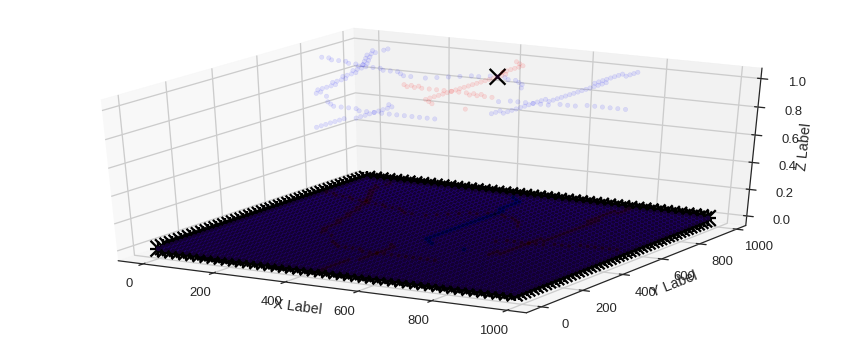

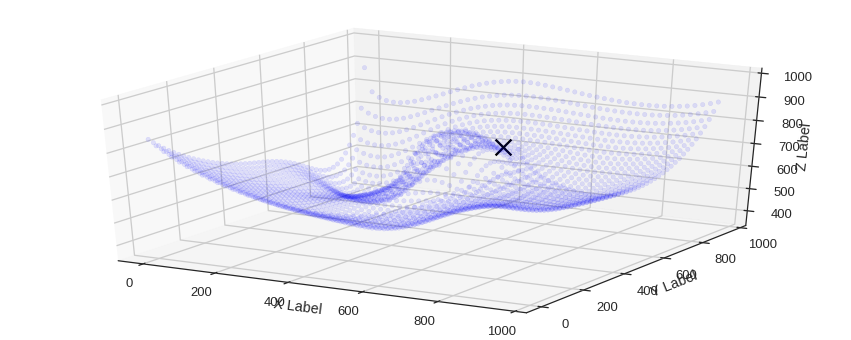

[ 500.          760.          675.69244385] []


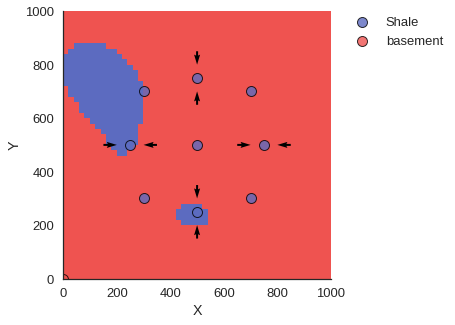

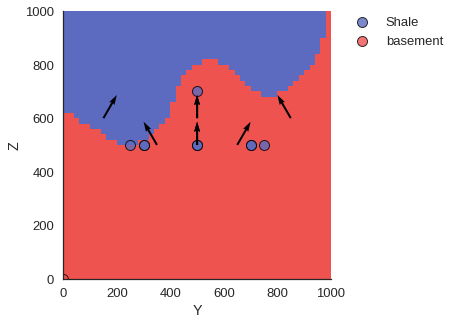

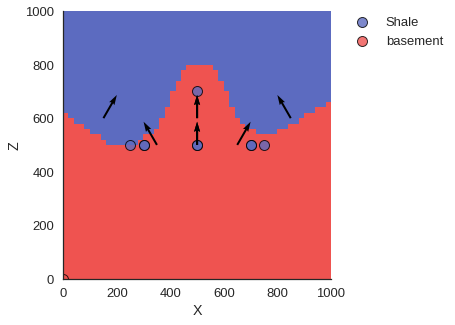

In [42]:
@pymc.deterministic
def interp_unc(value=0, z_unc=z_unc):
    
    print('Variation by:', z_unc*rescale_f)
    ###
    new_A_z_sst = A_z_sst + z_unc
    
    new_B_z_sst = B_z_sst + z_unc/2
    #new_C_z_sst = new_A_z_sst
    new_D_z_sst = D_z_sst + (z_unc/2)*(-1)
    new_E_z_sst = D_z_sst + z_unc*(-1)
    new_F_z_sst = F_z_sst + (z_unc/2)*(-1)
    #new_G_z_sst = new_A_z_sst
    new_H_z_sst = H_z_sst + z_unc/2
    
    ###
    interp_data.geo_data_res.interfaces.loc[0,'Z'] = new_F_z_sst
    interp_data.geo_data_res.interfaces.loc[1,'Z'] = new_D_z_sst
    interp_data.geo_data_res.interfaces.loc[2,'Z'] = new_A_z_sst
    #interp_data.geo_data_res.interfaces.loc[3,'Z'] = new_G_z_sst
    #interp_data.geo_data_res.interfaces.loc[4,'Z'] = new_C_z_sst
    interp_data.geo_data_res.interfaces.loc[5,'Z'] = new_E_z_sst
    interp_data.geo_data_res.interfaces.loc[6,'Z'] = new_H_z_sst
    interp_data.geo_data_res.interfaces.loc[7,'Z'] = new_B_z_sst
   
    return interp_data

@pymc.deterministic
def structural_model(interp_data_M=interp_unc, shale_n=shale_n, print_figures=True):
    lith_sol, fault_sol = gp.compute_model(interp_data_M)
    lith_block = lith_sol[0]
    
    #fault_block = fault_sol[0]  
    shale_surf_v, shale_surf_s = gp.get_surfaces(\
        interp_data = interp_data_M, potential_lith=lith_sol[1], n_formation = shale_n)
    #max_vol, trap, SSF, trap_control = max_trap_vol(interp_data_M, lith_block, fault_block, seal_surf_v, seal_th)
    #print("Maximum trap volume: %s m³" % max_vol)
    a_spill, f_leak = spill_leak_P(interp_data_M, shale_surf_v, lith_block, print_figures)
    print(a_spill, f_leak)
    
    if print_figures:
        plt.figure(1)
        gp.plotting.plot_section(geo_data, lith_sol[0], 
                                 int(resolution/2), plot_data =1, direction='z')
        plt.figure(2)
        gp.plotting.plot_section(geo_data, lith_sol[0], 
                                 int(resolution/2), plot_data =1, direction='x')
        plt.figure(3)
        gp.plotting.plot_section(geo_data, lith_sol[0], 
                                 int(resolution/2), plot_data =1, direction='y')
        #gp.plotting.plot_section(geo_data, trap, int(resolution/2), plot_data =0)
    return lith_sol#, fault_sol, max_vol, trap, SSF, trap_control


In [45]:
iterations = 20
model = pymc.Model([interp_unc, z_unc, structural_model])

/home/bl9/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:116: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.


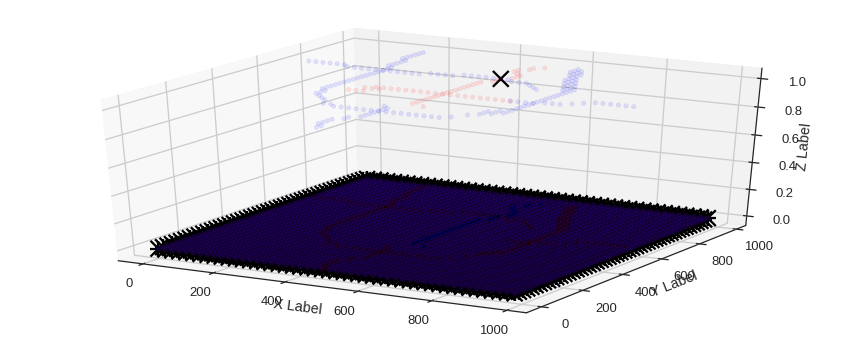

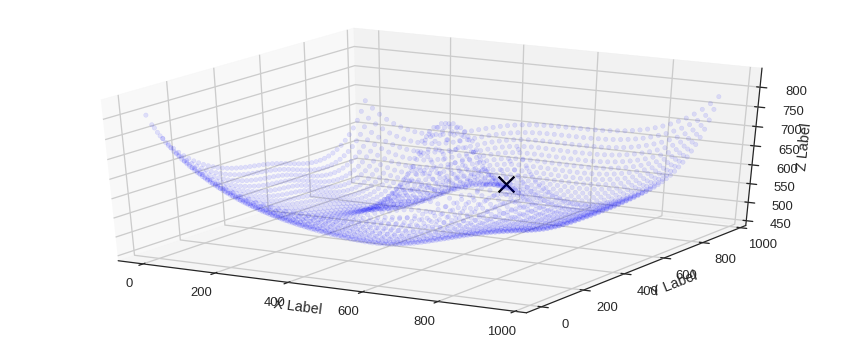

[ 520.        740.        547.552948] []
Variation by: -6.13309339419


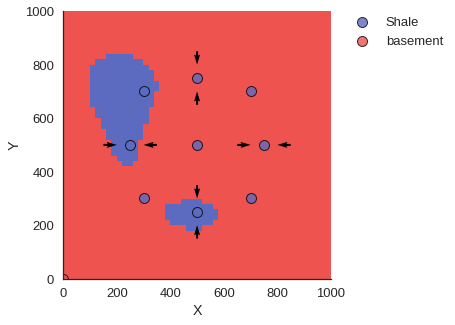

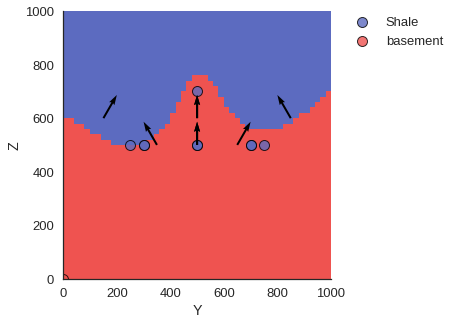

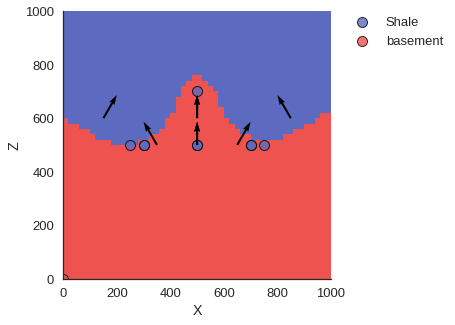

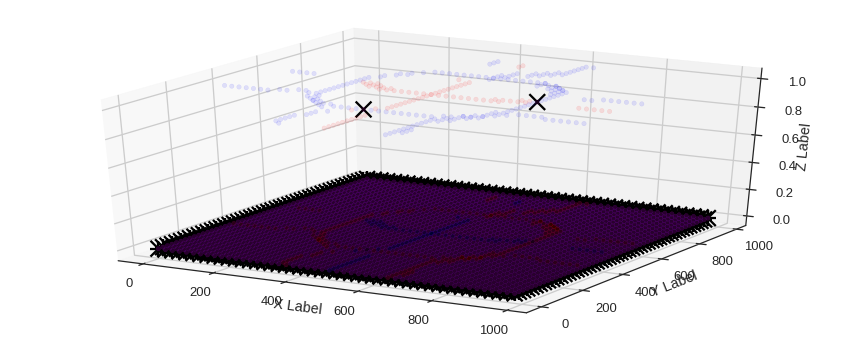

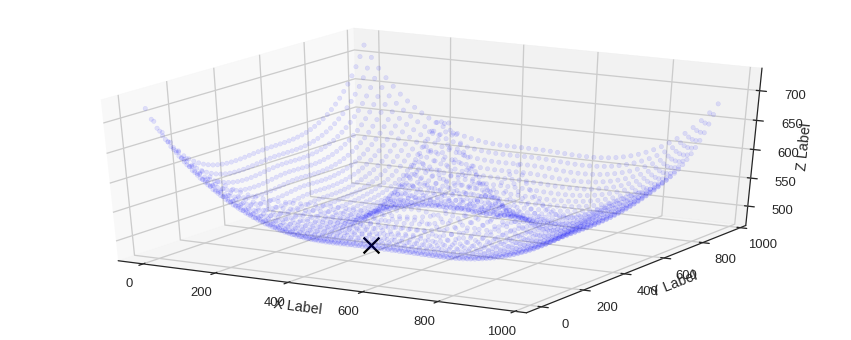

[ 440.          240.          490.34397125] []
 [---              10%                  ] 2 of 20 complete in 15.1 secVariation by: -14.5638501804


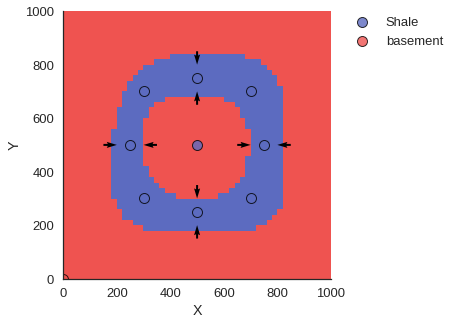

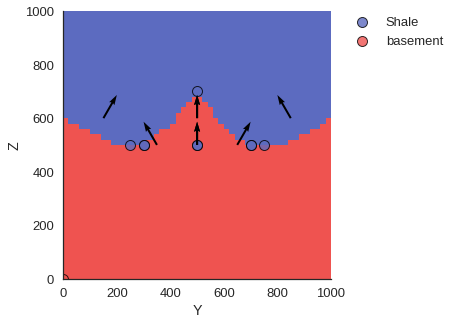

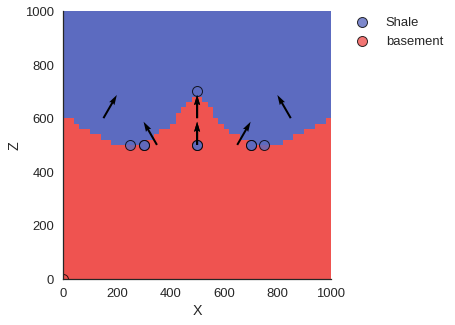

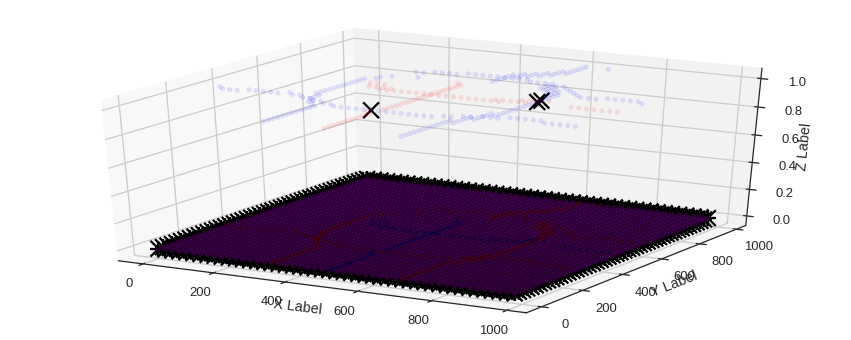

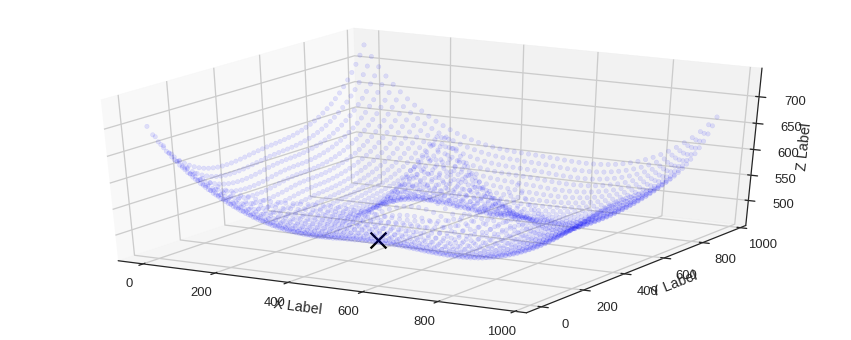

[ 460.          240.          490.21900177] []
 [-----            15%                  ] 3 of 20 complete in 24.1 secVariation by: 115.105370873


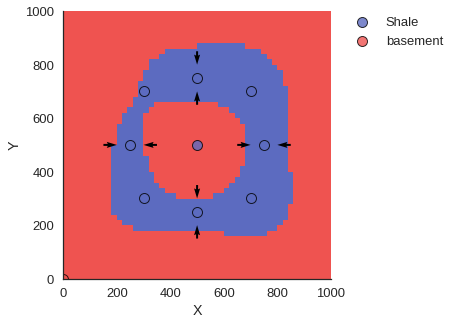

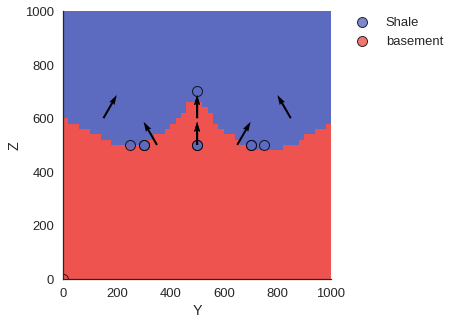

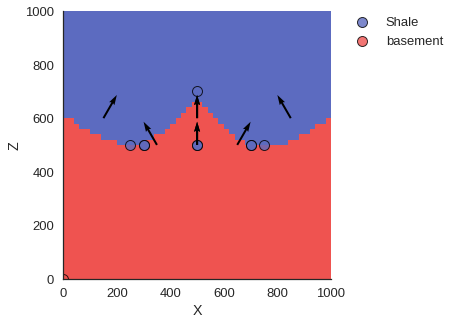

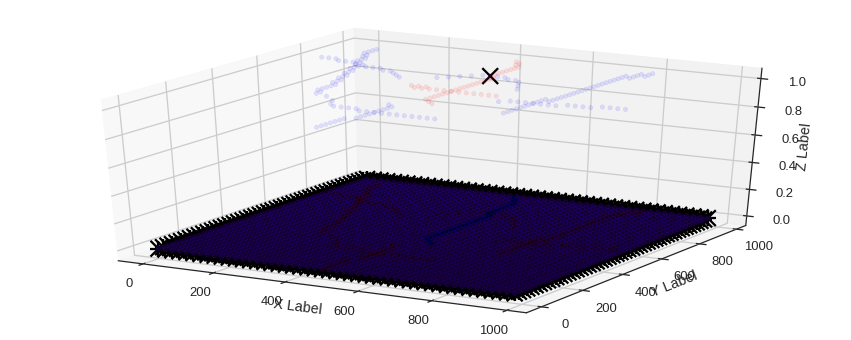

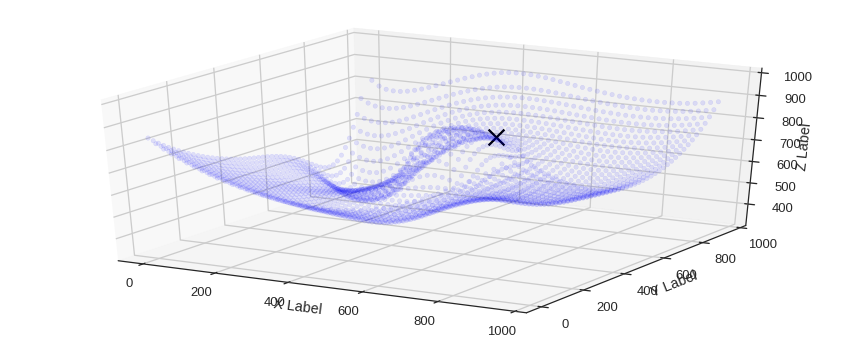

[ 480.          760.          695.81825256] []
 [-------          20%                  ] 4 of 20 complete in 31.4 secVariation by: -11.6503454322


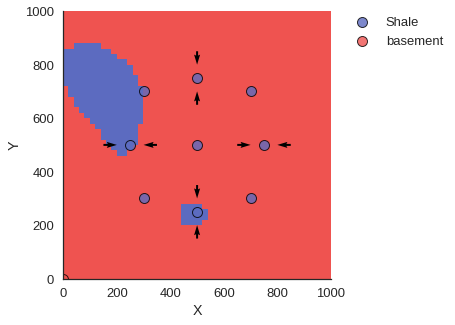

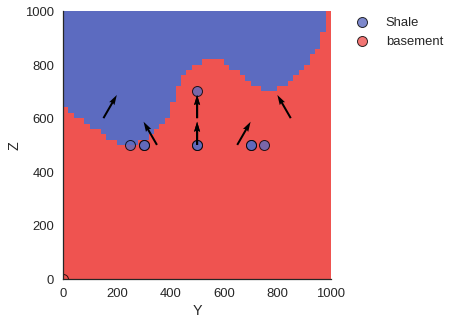

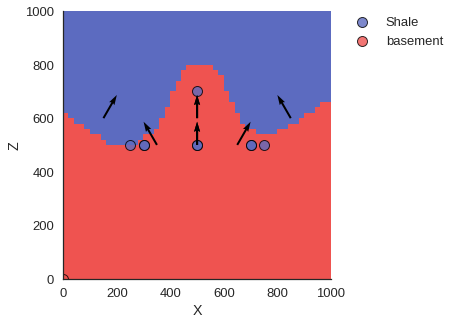

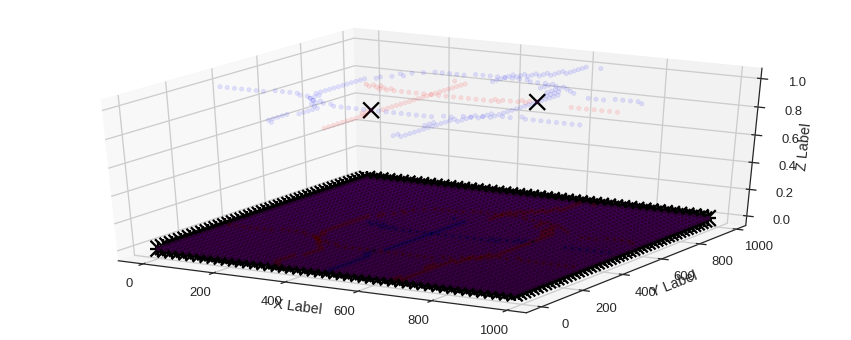

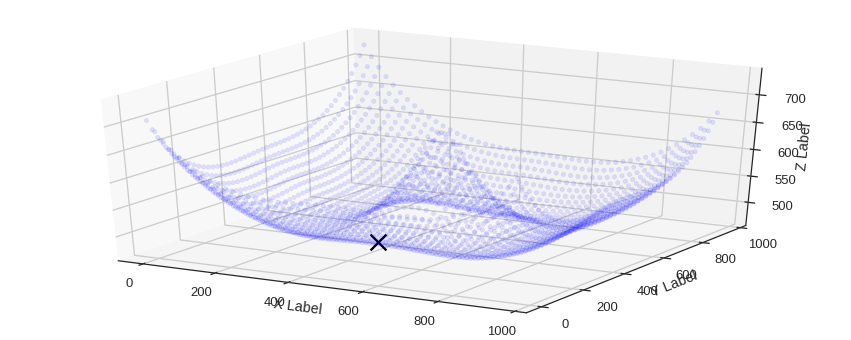

[ 460.         240.         490.2437973] []
 [---------        25%                  ] 5 of 20 complete in 38.3 secVariation by: -20.6130281303


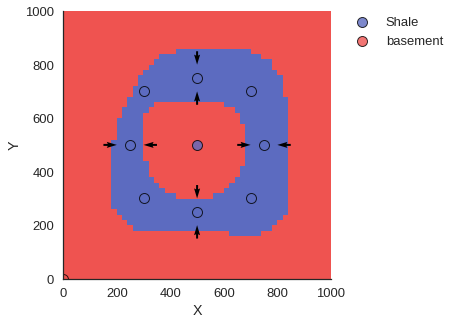

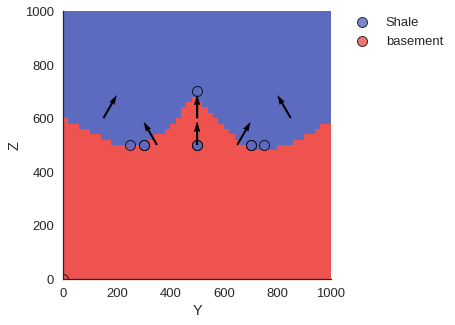

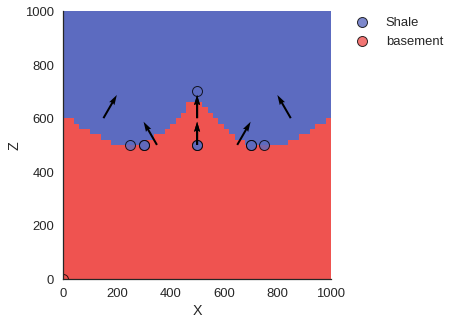

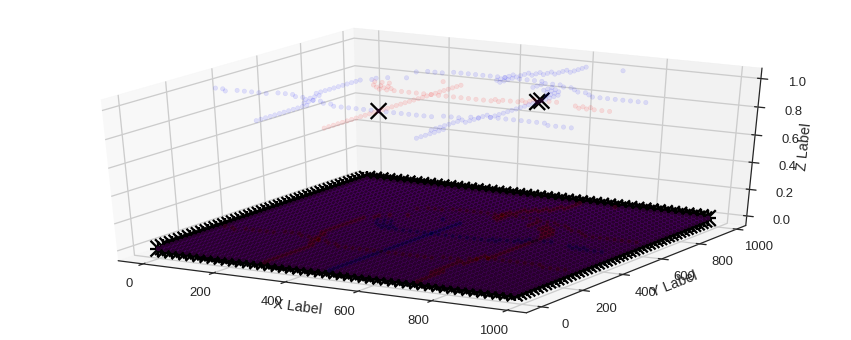

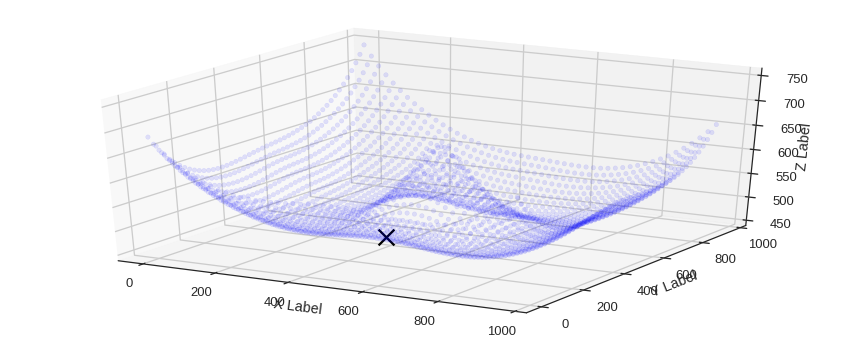

[ 480.          240.          490.21980286] []
 [-----------      30%                  ] 6 of 20 complete in 46.0 secVariation by: -25.8498718111


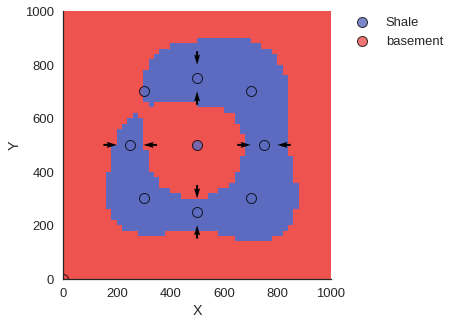

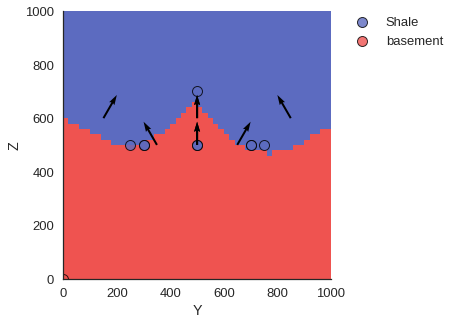

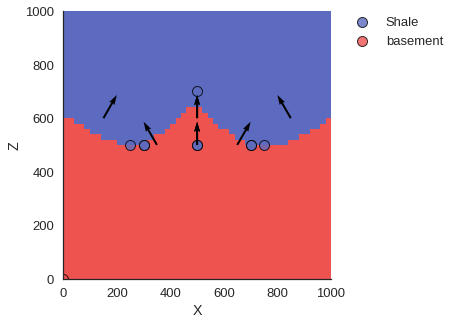

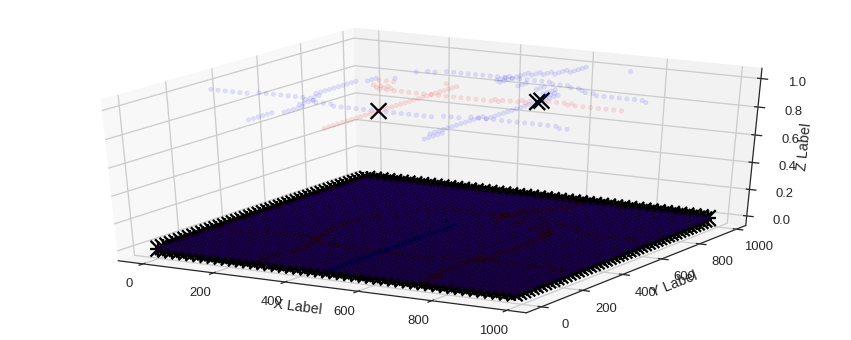

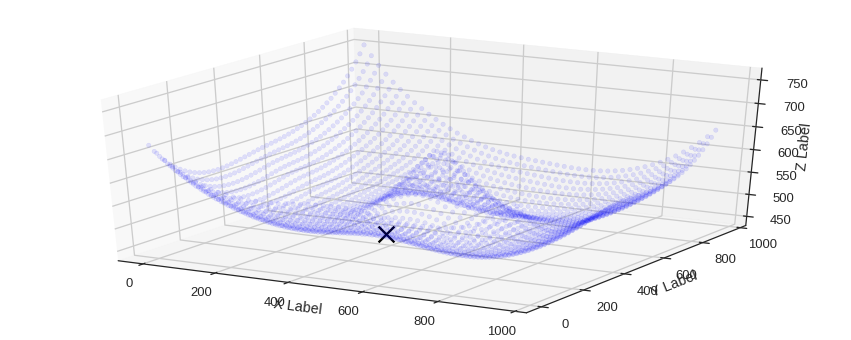

[ 480.          240.          490.23231506] []
 [-------------    35%                  ] 7 of 20 complete in 54.0 secVariation by: -159.331475212


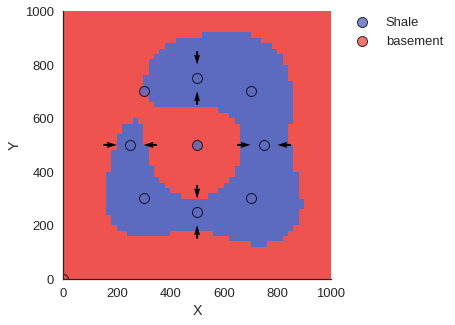

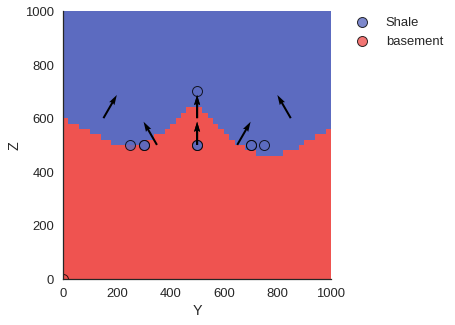

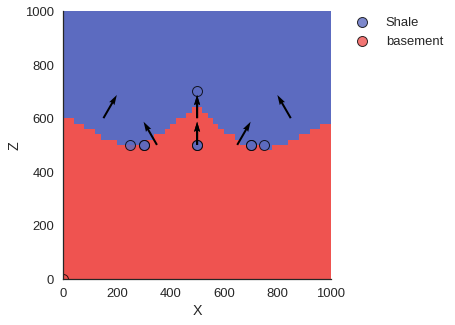

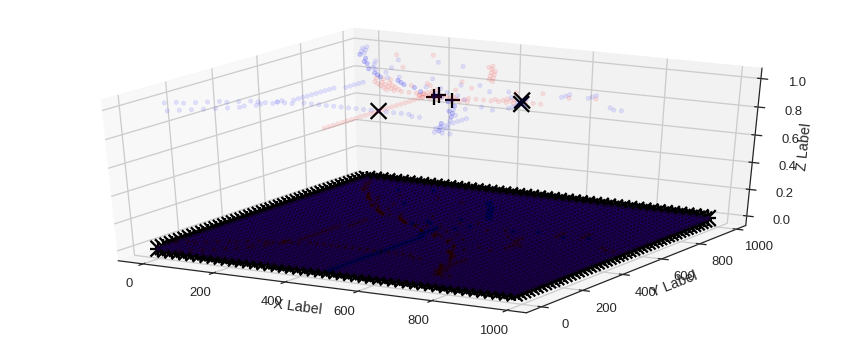

 [---------------  40%                  ] 8 of 20 complete in 59.9 secVariation by: -32.7477516366
Variation by: -11.4943420495
Variation by: 1.14682060683
Variation by: -46.9888654573
Variation by: 37.466626169
Variation by: 35.0209594687
Variation by: 14.3654818095
Variation by: -20.630339257
Variation by: 45.6958205432
Variation by: -20.847615993
Variation by: 3.96287500844
Variation by: 55.0995449212
Variation by: -23.2177837828
 [-----------------100%-----------------] 20 of 20 complete in 60.0 sec

/home/bl9/anaconda3/lib/python3.5/site-packages/pymc/database/base.py:282: UserWarning: 
Error tallying structural_model, will not try to tally it again this chain.
Did you make all the samevariables and step methods tallyable
as were tallyable last time you used the database file?

Error:

Traceback (most recent call last):
  File "/home/bl9/anaconda3/lib/python3.5/site-packages/pymc/database/base.py", line 272, in tally
    self._traces[name].tally(chain)
  File "/home/bl9/anaconda3/lib/python3.5/site-packages/pymc/database/ram.py", line 94, in tally
    value = self._getfunc()
  File "/home/bl9/anaconda3/lib/python3.5/site-packages/pymc/PyMCObjects.py", line 468, in get_value
    _value = self._value.get()
  File "LazyFunction.pyx", line 280, in pymc.LazyFunction.LazyFunction.get (pymc/LazyFunction.c:2568)
  File "<ipython-input-42-de88e30ec4c9>", line 37, in structural_model
    a_spill, f_leak = spill_leak_P(interp_data_M, shale_surf_v, lith_block, print_figures)
  File "<ipython-

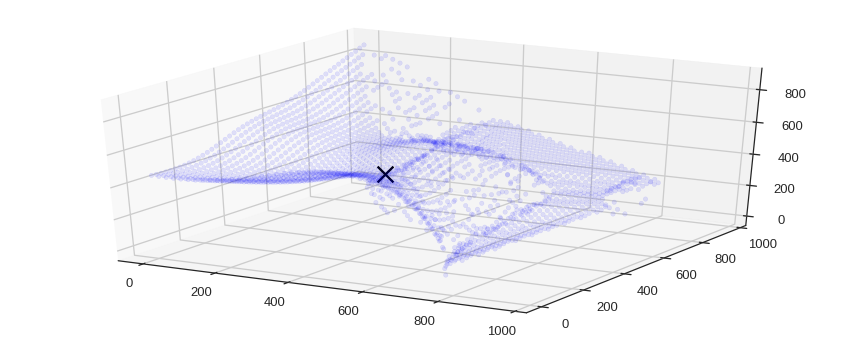

In [46]:
M = pymc.MCMC(model)
#M = pymc.MCMC(model,db= "hdf5" , dbname= "D:/PyMC_DataBase/prior_model_noBlocks_SSFc_3_1000iter_2017_11_12")
M.sample(iter=iterations)